# Preprocessing P1902 with Scanpy

Here we load the data from P1902:  In vitro, in vivo, and bulks.  We keep these separate throughout.  We load the metadata, expression matrices, and we load gene metadata (from the BioMart).  We put all this together into three Scanpy AnnData objects, and then carry out various steps of filtering and normalization.

# Loading packages

In [1]:
import pandas as pd  # Pandas for data analysis.
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt  # For basic plotting.
import seaborn as sns # For pretty visualization in Seaborn.  See https://seaborn.pydata.org/
from IPython.display import display # Pretty display of data frames.

from sklearn import base
from sklearn.feature_selection import chi2, f_classif

import scanpy as sc
sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

# Put plots inline rather than in a pop-up.
%matplotlib inline

scanpy==1.7.1 anndata==0.7.6 umap==0.5.1 numpy==1.20.1 scipy==1.6.1 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


In [2]:
file_prefix = 'Processed/'
file_suffix = '.loom'

In [3]:
def hrule(repchar = '=', length=80):
    '''
    A quick function to print a horizontal line.
    '''
    if len(repchar) == 1:
        print(repchar*length)

# Loading data

## Getting gene data

Gene data was downloaded [GRCh7 at the biomart](https://grch37.ensembl.org/info/data/biomart/index.html), and we work at the level of distinct Ensembl IDs.  Transcript length (used for TPM normalization) is obtained by averaging all entries with a given Ensembl ID.

In [4]:
def get_genes(filename, verbose=True):
    gene_raw = pd.read_csv(filename, sep='\t', index_col=0, header=0, low_memory=False)
    gene_raw.columns = ['transcript_length', 'gene_name', 'GC_content','transcript stable ID', 'TSS']
    if verbose:
        print('{} genes found in {}.'.format(len(gene_raw), filename))
    
    gene_lengths = gene_raw['transcript_length'].groupby(gene_raw.index).mean()
    gene_GCs = gene_raw['GC_content'].groupby(gene_raw.index).mean()
    gene_df = pd.DataFrame(gene_lengths, index=gene_lengths.index)
    gene_df['GC_content'] = gene_GCs
    gene_df['gene_name'] = gene_raw['gene_name'].groupby(gene_raw.index).first()
    if verbose:
        print('{} distinct Ensembl gene IDs found.'.format(len(gene_df)))
        display(gene_df.head())
    return gene_df

In [5]:
gene_df = get_genes('Raw/GRCh37_Biomart.txt')

215404 genes found in Raw/GRCh37_Biomart.txt.
63677 distinct Ensembl gene IDs found.


,transcript_length,GC_content,gene_name
Gene stable ID,,,
ENSG00000000003,1350.333333,40.87,TSPAN6
ENSG00000000005,940.500000,40.80,TNMD
ENSG00000000419,974.714286,39.85,DPM1
ENSG00000000457,3274.400000,40.14,SCYL3
ENSG00000000460,2197.200000,39.22,C1orf112


## Getting cell metadata

In [6]:
def get_meta(experiment, filename = '', report=True, invitro = True, invivo = False, bulks = False):
    df = pd.read_csv(filename, sep=',', index_col=1, header=0, low_memory=False)
    df = df.loc[df['Sample_ID'].notnull()] # Only keep cells with sample ID.
    print('Discarding samples without Sample ID.  {} samples remaining.'.format(len(df)))
    df['Project_ID'] = [sid[:5] for sid in df.index] 
    df = df[ df['Project_ID'] == experiment] # Only cells from the experiment.
    print('{} samples found in experiment {}.'.format(len(df), experiment))
    
    df = df.loc[df['Clone_ID'].notnull()] # Only keep cells with Clone ID.
    print('Discarding samples without Clone ID.  {} samples remaining.'.format(len(df)))
    if invitro:
        df = df.loc[df['Condition'] == 'In_Vitro'] 
        print('Discarding samples that are not in-vitro.  {} samples remaining'.format(len(df)))
    elif invivo:
        df = df.loc[df['Condition'] == 'In_Vivo'] 
        print('Discarding samples that are not in-vivo.  {} samples remaining'.format(len(df)))
    df.drop('Sample_ID', axis=1, inplace=True)
    df.index = [cn[:-1] for cn in df.index]
    if bulks:
        df = df[ df['Cell_Number'] > 1] # Include only bulks.
        print('Discarding single cells.  {} bulks remaining'.format(len(df)))
    else:
        df = df[ df['Cell_Number'] == 1] # Get rid of bulks.
        print('Discarding bulks.  {} single cells remaining'.format(len(df)))
    if report:
        if bulks:
            print('{} bulks found in experiment {}'.format(len(df), experiment))
        else:
            print('{} single cells found in experiment {}'.format(len(df), experiment))
        clones = df['Clone_ID'].unique()
        print('{} Clones: {}'.format(len(clones), ', '.join(clones)))
        print('The first five rows of the dataframe are below')
        display(df[:5])
    return df

In [7]:
meta_vitro = get_meta('P1902', filename = 'Raw/metadata_marty_NFCORE_Sept2019.csv')
cells_vitro = list(meta_vitro.index)

Discarding samples without Sample ID.  2345 samples remaining.
667 samples found in experiment P1902.
Discarding samples without Clone ID.  624 samples remaining.
Discarding samples that are not in-vitro.  370 samples remaining
Discarding bulks.  361 single cells remaining
361 single cells found in experiment P1902
9 Clones: E4, A7, A8, G6, G8, H2, H9, B4, F3
The first five rows of the dataframe are below


,Condition,Cell_Number,Clone_ID,Day,In_Vivo_Clone_ID,Project_ID
P1902_1289,In_Vitro,1.0,E4,NaN,NaN,P1902
P1902_1290,In_Vitro,1.0,E4,NaN,NaN,P1902
P1902_1291,In_Vitro,1.0,E4,NaN,NaN,P1902
P1902_1292,In_Vitro,1.0,E4,NaN,NaN,P1902
P1902_1293,In_Vitro,1.0,A7,NaN,NaN,P1902


In [8]:
meta_vivo = get_meta('P1902', filename = 'Raw/metadata_marty_NFCORE_Sept2019.csv', invitro = False, invivo = True)
cells_vivo = list(meta_vivo.index)

Discarding samples without Sample ID.  2345 samples remaining.
667 samples found in experiment P1902.
Discarding samples without Clone ID.  624 samples remaining.
Discarding samples that are not in-vivo.  254 samples remaining
Discarding bulks.  254 single cells remaining
254 single cells found in experiment P1902
78 Clones: 92, 93, 94, 410, 95, 0, 149, 361, 97, 98, 100, 102, 103, 104, 106, 107, 108, 109, 111, 280, 112, 115, 147, 118, 119, 121, 122, 124, 125, 126, 127, 129, 130, 131, 132, 134, 137, 140, 142, 143, 150, 160, 222, 224, 225, 226, 227, 228, 229, 189, 230, 272, 234, 235, 183, 240, 153, 241, 242, 243, 244, 247, 174, 248, 176, 255, 162, 275, 273, 304, 353, 15, 356, 329, 359, 364, 192, 321
The first five rows of the dataframe are below


,Condition,Cell_Number,Clone_ID,Day,In_Vivo_Clone_ID,Project_ID
P1902_1001,In_Vivo,1.0,92,136.0,NaN,P1902
P1902_1002,In_Vivo,1.0,93,136.0,NaN,P1902
P1902_1003,In_Vivo,1.0,94,136.0,NaN,P1902
P1902_1004,In_Vivo,1.0,410,136.0,NaN,P1902
P1902_1005,In_Vivo,1.0,95,136.0,NaN,P1902


In [9]:
meta_bulks = get_meta('P1902', filename = 'Raw/metadata_marty_NFCORE_Sept2019.csv', bulks=True)
bulks = list(meta_bulks.index)

Discarding samples without Sample ID.  2345 samples remaining.
667 samples found in experiment P1902.
Discarding samples without Clone ID.  624 samples remaining.
Discarding samples that are not in-vitro.  370 samples remaining
Discarding single cells.  9 bulks remaining
9 bulks found in experiment P1902
4 Clones: E4, A7, H2, B4
The first five rows of the dataframe are below


,Condition,Cell_Number,Clone_ID,Day,In_Vivo_Clone_ID,Project_ID
P1902_1380,In_Vitro,50.0,E4,NaN,NaN,P1902
P1902_1382,In_Vitro,50.0,A7,NaN,NaN,P1902
P1902_1384,In_Vitro,50.0,A7,NaN,NaN,P1902
P1902_1570,In_Vitro,50.0,H2,NaN,NaN,P1902
P1902_1571,In_Vitro,50.0,H2,NaN,NaN,P1902


## Getting expression matrices

In [10]:
def get_counts(filename, gdf):
    df = pd.read_csv(filename, sep='\t',
                     index_col=0, header=0, low_memory=False)
    df = df[df.columns[1:]]
    cols = list(df.columns)
    cols = ['_'.join(col.split('_')[3:5]) for col in cols]
    df.columns = cols
    return df

In [11]:
foldername = 'Raw/NFCore_Joanna_Mapped_Sept2019/'
counts_all = get_counts(foldername+'P1902_merged_gene_counts.tsv', gene_df)
counts_bulks = counts_all[bulks]
counts_vitro = counts_all[cells_vitro]
counts_vivo = counts_all[cells_vivo]
counts_vitro.head()

,P1902_1289,P1902_1290,P1902_1291,P1902_1292,P1902_1293,P1902_1294,P1902_1295,P1902_1296,P1902_1297,P1902_1298,...,P1902_1660,P1902_1661,P1902_1662,P1902_1663,P1902_1664,P1902_1665,P1902_1669,P1902_1670,P1902_1671,P1902_1672
Geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000223972,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000227232,20,23,0,0,0,0,0,48,0,0,...,17,0,7,0,15,71,0,0,0,0
ENSG00000243485,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000237613,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000268020,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Moving into Scanpy

We move the expression matrices, with information about genes and cells, into Scanpy's AnnData objects.

In [12]:
def moveto_scanpy(counts, cell_meta, gene_meta, plain_name = True):
    adata = sc.AnnData(counts.T)
    for gene_property in gene_meta.columns:
        adata.var[gene_property] = gene_meta[gene_property]
    for cell_property in cell_meta.columns:
        adata.obs[cell_property] = cell_meta[cell_property]
    if plain_name:
        adata.var.index = adata.var['gene_name'] # Reindex by gene name
        adata.var_names_make_unique() # Use common gene names, but uniquify them.
    
    return adata

In [13]:
adata = {}
adata['invitro'] = moveto_scanpy(counts_vitro, meta_vitro, gene_df)
adata['invivo'] = moveto_scanpy(counts_vivo, meta_vivo, gene_df)
adata['bulks'] = moveto_scanpy(counts_bulks, meta_bulks, gene_df)

datasets = ['invitro','invivo','bulks']

/opt/anaconda3/envs/clonalomics/lib/python3.8/site-packages/anndata/utils.py:111: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD113-1', 'SNORD113-2']
  warnings.warn(


# Normalization and filtering

Now we add annotations for highly variable genes.

In [14]:
for ds in datasets:
    print('Identifying highly variable genes in {}'.format(ds))
    sc.pp.highly_variable_genes(adata[ds], n_top_genes=7500, flavor='seurat_v3')

Identifying highly variable genes in invitro


/opt/anaconda3/envs/clonalomics/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


Identifying highly variable genes in invivo
Identifying highly variable genes in bulks


Now we carry out TPM normalization. 

In [15]:
def TPM_norm(ad, target_sum=1e6):
    ad_out = ad.copy()
    
    df = ad_out.to_df().T
    
    # Step 1:  divide each entry by the transcript length of the gene, in kilobases.
    rdf = 1 / ad_out.var['transcript_length']
    df = df.mul(1000*rdf,axis=0) # Multiply by 1000 to convert transcript length to kilobases.
    
    # Transpose for what follows.
    df = df.T
    
    # Step 2:  divide each entry by cell-total, then multiply by target_sum.
    rdf = 1/df.sum(axis=1)
    df = df.mul(rdf, axis=0)
    df = df * target_sum 
    
    # Double-check TPM normalization has succeeded.
    print('The TPM normalization has failed for {} samples.'.format(((df.sum(axis=1) - target_sum) > 0.1).sum()))
    
    # Return new dataframe.
    ad_out.X = df
    return ad_out

In [16]:
for ds in datasets:
    adata[ds] = TPM_norm(adata[ds]) # TPM normalize.

The TPM normalization has failed for 0 samples.
The TPM normalization has failed for 0 samples.
The TPM normalization has failed for 0 samples.


We keep genes if they are expressed at TPM > 10 for more than 5% of cells.

In [17]:
for ds in datasets:
    genes_before = adata[ds].n_vars
    gg = ((adata[ds].to_df() > 10).sum() > 0.05*adata[ds].n_obs)
    good_genes = gg[gg].index
    adata[ds] = adata[ds][:,good_genes]
    genes_after = adata[ds].n_vars
    print('Dataset {} has {} genes before and {} genes after filtering.'.format(ds,genes_before,genes_after))

Dataset invitro has 63677 genes before and 7504 genes after filtering.
Dataset invivo has 63677 genes before and 7116 genes after filtering.
Dataset bulks has 63677 genes before and 9172 genes after filtering.


Pseudo-log normalization is next.

In [18]:
for ds in datasets:
    sc.pp.log1p(adata[ds]) #pseudo-log normalize.

/opt/anaconda3/envs/clonalomics/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:343: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [19]:
for ds in datasets:
    print('Summary of AnnData object for {} (shape = #samples x #genes)'.format(ds))
    print(adata[ds])
    hrule()

Summary of AnnData object for invitro (shape = #samples x #genes)
AnnData object with n_obs × n_vars = 361 × 7504
    obs: 'Condition', 'Cell_Number', 'Clone_ID', 'Day', 'In_Vivo_Clone_ID', 'Project_ID'
    var: 'transcript_length', 'GC_content', 'gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'
Summary of AnnData object for invivo (shape = #samples x #genes)
AnnData object with n_obs × n_vars = 254 × 7116
    obs: 'Condition', 'Cell_Number', 'Clone_ID', 'Day', 'In_Vivo_Clone_ID', 'Project_ID'
    var: 'transcript_length', 'GC_content', 'gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'
Summary of AnnData object for bulks (shape = #samples x #genes)
AnnData object with n_obs × n_vars = 9 × 9172
    obs: 'Condition', 'Cell_Number', 'Clone_ID', 'Day', 'In_Vivo_Clone_ID', 'Project_ID'
    var: 'transcript_length', 'GC_content', 'gene_name', 'highly_varia

## Dropping T-cell Receptor Genes

We drop all T-cell receptor genes, from a given csv file.

In [24]:
def drop_TRs(ad, filename='TR_gene_data.csv'):
    ad_out = ad
    TR_gene_df = pd.read_csv(filename, index_col=0)
    TR_genes = TR_gene_df['gene_name'].values
    bad_genes = [gene for gene in ad_out.var_names if gene in TR_genes]
    print('{} genes removed.'.format(len(bad_genes)))
    keep_genes = [gene for gene in ad_out.var_names if not gene in bad_genes]
    ad_out = ad_out[:, keep_genes]
    return ad_out

In [25]:
for ds in datasets:
    before_genes = len(adata[ds].var_names)
    adata[ds] = drop_TRs(adata[ds])
    after_genes = len(adata[ds].var_names)
    print('{} T-cell receptor genes removed from adata[{}]'.format(before_genes - after_genes, ds))
    hrule()

64 genes removed.
64 T-cell receptor genes removed from adata[invitro]
61 genes removed.
61 T-cell receptor genes removed from adata[invivo]
88 genes removed.
88 T-cell receptor genes removed from adata[bulks]


# Quality control

/opt/anaconda3/envs/clonalomics/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/opt/anaconda3/envs/clonalomics/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/opt/anaconda3/envs/clonalomics/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


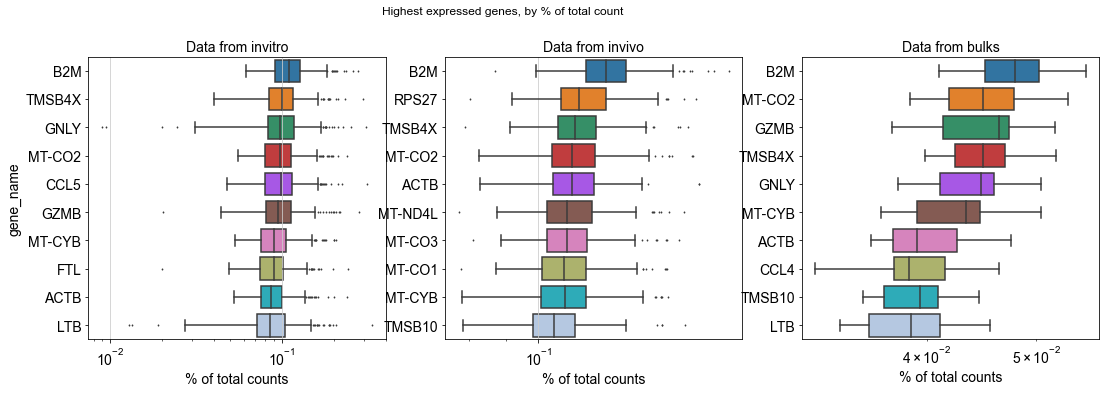

In [26]:
fig,ax = plt.subplots(1,len(datasets), figsize=(len(datasets)*6,5))
for j,ds in enumerate(datasets):
    sc.pl.highest_expr_genes(adata[ds], n_top=10, ax=ax[j], log=True, show=False)
    ax[j].set_title('Data from {}'.format(ds))
    if j > 0:
        ax[j].set_ylabel('')
plt.suptitle('Highest expressed genes, by % of total count', y=1.05)
plt.show()

In [27]:
for ds in datasets:
    adata[ds].var['mt'] = adata[ds].var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata[ds], qc_vars=['mt'], percent_top=None, inplace=True)

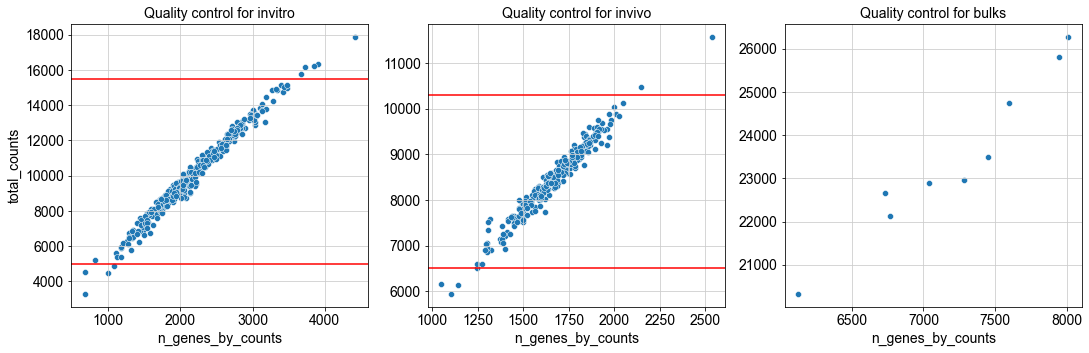

In [28]:
fig,ax = plt.subplots(1,len(datasets), figsize=(len(datasets)*6,5))
min_counts = {}
max_counts = {}
# max_genes = {}
for j,ds in enumerate(datasets):
    sns.scatterplot(x='n_genes_by_counts', y='total_counts', 
                    data=adata[ds].obs,  ax=ax[j])
    ax[j].set_title('Quality control for {}'.format(ds))
    if ds == 'invitro':
        min_counts[ds] = 5000 # Chosen after plotting!
        max_counts[ds] = 15500  # Chosen after plotting!
        # max_genes[ds] = 3200 # Chosen after plotting
        ax[j].axhline(min_counts[ds], color='red')
        ax[j].axhline(max_counts[ds], color='red')
        # ax[j].axvline(max_genes[ds], color='red')
    elif ds == 'invivo':
        min_counts[ds] = 6500  # Chosen after plotting!
        max_counts[ds] = 10300  # Chosen after plotting!
        # max_genes[ds] = 2500
        ax[j].axhline(min_counts[ds], color='red')
        ax[j].axhline(max_counts[ds], color='red')
        # ax[j].axvline(max_genes[ds], color='red')
    if j > 0:
        ax[j].set_ylabel('')
plt.show()

We use the above plots to filter out cells based on min/max total counts.  We delete cells above and below the red lines.

In [29]:
for ds in ['invitro','invivo']:
    sc.pp.filter_cells(adata[ds], min_counts=min_counts[ds])
    sc.pp.filter_cells(adata[ds], max_counts=max_counts[ds])
    # sc.pp.filter_cells(adata[ds], max_genes=max_genes[ds])


In [30]:
for ds in datasets:
    print(adata[ds])
    hrule()

AnnData object with n_obs × n_vars = 352 × 7440
    obs: 'Condition', 'Cell_Number', 'Clone_ID', 'Day', 'In_Vivo_Clone_ID', 'Project_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'transcript_length', 'GC_content', 'gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'hvg', 'log1p'
AnnData object with n_obs × n_vars = 249 × 7055
    obs: 'Condition', 'Cell_Number', 'Clone_ID', 'Day', 'In_Vivo_Clone_ID', 'Project_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'transcript_length', 'GC_content', 'gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances

# Gene metrics

Here we annotate each gene with metrics which will be used later.  

## Highly variable genes
The first is a ranking for highly variable genes.  Before normalization, we used Scanpy's [highly variable genes](https://scanpy.readthedocs.io/en/stable/api/scanpy.pp.highly_variable_genes.html) function, which annotates the highly variable genes using the methods of Seurat v3. Here we examine the 10 most variable genes.

In [31]:
adata['invitro'].var.highly_variable_rank.sort_values()[:10]

gene_name
HIST1H4C     1.0
CSF2         3.0
EGR1         5.0
RRM2         6.0
LRRC28       8.0
IFNG         9.0
STMN1       10.0
CCL4L1      11.0
CCL4        13.0
TNFRSF9     14.0
Name: highly_variable_rank, dtype: float32

## Always on genes

Some genes are "always on" -- almost every cell expressed the gene above some minimum threshold.  We add a statistic for the percentage of cells in which the gene is expressed above a threshold of 10 (TPM-normalized count).

In [32]:
def on_ratio(ad, threshold=10):
    ad_out = ad.copy()
    EM = ad_out.to_df() 
    ad_out.var['on_ratio'] = (EM > np.log1p(10)).sum() / len(EM)
    return ad_out

In [33]:
for ds in datasets:
    adata[ds] = on_ratio(adata[ds])

## Clonality statistics

We annotate genes based on statistics for clonality:  ANOVA F, Kruskal-Wallis, and chi^2 (after binarization).

In [34]:
def group_stats(ad, groupby='Clone_ID'):
    X = ad.to_df()
    y = ad.obs[groupby]
    F_pvals = ss.f_oneway(*[X[y == k] for k in np.unique(y)])[1]
    print('ANOVA F complete.  Kruskal-Wallis may take a minute now.')
    K_pvals = X.apply(lambda col : ss.kruskal(*[col[y == k] for k in np.unique(y)])[1])
    chi2_pvals = chi2(X > np.log1p(10),y)[1]
    ad_out = ad.copy()
    ad_out.var['F_pval'] = F_pvals
    ad_out.var['K_pval'] = K_pvals
    ad_out.var['chi2_pval'] = chi2_pvals
    return ad_out

In [35]:
for ds in ['invitro','invivo']:
    adata[ds] = group_stats(adata[ds])

ANOVA F complete.  Kruskal-Wallis may take a minute now.
ANOVA F complete.  Kruskal-Wallis may take a minute now.


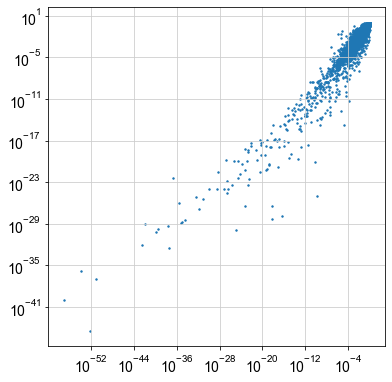

In [36]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
plt.scatter(adata['invitro'].var.F_pval, adata['invitro'].var.K_pval, s=2)
ax.set_xscale('log')
ax.set_yscale('log')

In [37]:
adata['invitro'].var.F_pval.sort_values()[:20]

gene_name
LRRC28        8.880743e-58
PLS3-1        1.667508e-54
REG4          8.464216e-53
AMICA1        8.199574e-52
AC010970.2    4.236294e-43
KLRC2         1.633467e-42
CXCR6         1.818976e-40
KLRC3         3.456316e-40
KLRD1         2.097459e-38
ANXA1         3.816226e-38
CD2           1.899148e-37
IL32          2.576189e-36
TIMD4         6.301630e-36
GPR15         9.530395e-36
CCL4L1        4.117727e-35
KLRB1         4.317542e-33
MALAT1        1.795721e-32
KLRC1         9.660744e-32
ALOX5AP       1.133864e-30
CCL3L1        3.336896e-29
Name: F_pval, dtype: float64

## Pathway annotation

We annotate some genes based on a custom list of gene pathways.

In [38]:
pathway_df = pd.read_csv('Raw/Pathway_List_Feb182020_JEMcurated.csv')
pathways = list(pathway_df.columns)
print('Adding annotation for the following pathways: {}'.format(', '.join(pathways)))

Adding annotation for the following pathways: CD3/TCR Signaling, Cytotoxicity, Exhaustion, IL-2R Signaling, Ribosomal Processes, MT-genes, Mitochondrial Respiration, Interferon Signaling


In [39]:
def add_paths(ad):
    ad_out = ad.copy()
    ad_out.var['pathway'] = ''
    for pathway in pathways:
        pathgenes = pathway_df[pathway].dropna().values
        for gene in pathgenes:
            if gene in ad_out.var_names:
                ad_out.var.loc[gene,'pathway'] = pathway
    return ad_out
    #[gene for gene in pathway_df[pathway].values if type(gene) == str]

In [40]:
for ds in datasets:
    adata[ds] = add_paths(adata[ds])

# Saving data

Don't forget to save the data!  Here we save data in loom files.

In [41]:
for ds in datasets:
    print('Summary of {} data'.format(ds))
    print(adata[ds])
    hrule()

Summary of invitro data
AnnData object with n_obs × n_vars = 352 × 7440
    obs: 'Condition', 'Cell_Number', 'Clone_ID', 'Day', 'In_Vivo_Clone_ID', 'Project_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'transcript_length', 'GC_content', 'gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'on_ratio', 'F_pval', 'K_pval', 'chi2_pval', 'pathway'
    uns: 'hvg', 'log1p'
Summary of invivo data
AnnData object with n_obs × n_vars = 249 × 7055
    obs: 'Condition', 'Cell_Number', 'Clone_ID', 'Day', 'In_Vivo_Clone_ID', 'Project_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'transc

In [42]:
for ds in datasets:
    filename = file_prefix+'P1902_'+ds+file_suffix
    adata[ds].write_loom(filename)
    print('Data written to {}'.format(filename))

Data written to Processed/P1902_invitro.loom
Data written to Processed/P1902_invivo.loom
Data written to Processed/P1902_bulks.loom
